### Garbage classifier with EfficientNetB3  

Обучение на Google Colab. Как хранилище используется Google Drive.

Датасет с 12 классами изображений в .zip архиве.


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.listdir('drive/MyDrive/garbage_classifier/')

['trained_model', '12_class_garbage_classification_dataset.zip']

### Разархивация датасета с изображениями

In [4]:
import zipfile

zip_file = 'drive/MyDrive/garbage_classifier/12_class_garbage_classification_dataset.zip'

z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [5]:
# Директория датасета
path_dataset = 'garbage_classification_dataset/'
os.listdir(path_dataset)

['cardboard',
 'paper',
 'plastic',
 'white-glass',
 'biological',
 'battery',
 'clothes',
 'shoes',
 'trash',
 'metal',
 'green-glass',
 'brown-glass']

### Импорт необходимых библиотек

In [6]:
import os
import time
import shutil
import logging

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Activation, Dropout, Conv2D,
                                     MaxPooling2D, BatchNormalization, Flatten)
import numpy as np
import pandas as pd
import cv2 as cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Отключение сообщений с предупреждениями от tensorflow
logging.getLogger("tensorflow").setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
sns.set_style('darkgrid')

### Функция показа примеров тренировочных изображений

In [1]:
def show_image_samples(gen):
    """ Показ примеров изображений из полученного генератора.

    :param gen: Генератор изображений
    :return: None
    """
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    # Получение пачки изображений от генератора
    images, labels = next(gen)
    plt.figure(figsize=(20, 20))
    labels_length = len(labels)
    # Показ максимум 25 изображений
    images_count = labels_length if labels_length < 25 else 25

    for i in range(images_count):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

### Функция цветной печати текста

In [8]:
def print_in_color(txt_msg, fore_color, back_color):
    """ Цветной вывод текста.
    
    :param txt_msg: текст
    :type fore_color: tuple[int]
    :param fore_color: цвет текста
    :type back_color: tuple[int]
    :param back_color: цвет фона
    """
    rf, gf, bf = fore_color
    rb, gb, bb = back_color
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(
        bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'
    print(msg.format(mat), flush=True)
    # Возвращение цвета печати по умолчанию обратно к черному
    print('\33[0m', flush=True)
    return

### Callback для замера скорости обучения и вывода информации в виде таблицы.

In [9]:
class ControlCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold,
                 factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        """ Инициализация Callback.
        
        :param patience: Количество эпох без улучшения перед корректировкой
        скорости обучения
        :param stop_patience: Количество корректировок lr перед остановкой
        обучения
        :param threshold: Пороговое значение точности обучения, при котором lr
        будет корректироваться на основе потерь при проверке
        :param factor: Значение, но которое можно снизить скорость обучения
        :param batches: Количество обучающих пакетов изображений запускаемых
        за одну эпоху
        :param ask_epoch: Через сколько эпох спросить о продолжении
        """
        super(ControlCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.dwell = dwell
        self.batches = batches
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        # Сколько раз lr (learning rate) был уменьшен без улучшения
        self.count = 0
        self.stop_count = 0
        # Эпоха с наименьшими потерями      
        self.best_epoch = 1
        # Начальная скорость обучения
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        # Точность обучения     
        self.highest_tracc = 0.0
        # Минимальное значение потерь при валидации
        self.lowest_vloss = np.inf
        # Лучшие веса 
        self.best_weights = self.model.get_weights()
        # Начальные веса
        self.initial_weights = self.model.get_weights()

    def on_train_begin(self, logs=None):
        """ Выполняется перед началом обучения. """
        if self.base_model:
            if base_model.trainable:
                message = ('Инициализация Callback для обучения с обучаемой '
                           'base_model')
            else:
                message = ('Инициализация Callback для обучения с необучаемой '
                           'base_model')
        else:
            message = 'Инициализация Callback и началол обучения'
        print_in_color(message, (244, 252, 3), (55, 65, 80))
        message = (
            '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}'
            '{9:^8s}'.format(
                'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR',
                'Next LR', 'Monitor', '% Improv', 'Duration')
        )
        print_in_color(message, (244, 252, 3), (55, 65, 80))
        # Время начала всего обучения
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        """ Выполняется после окончания обучения. """
        # Вычисление времени, которое потрачено на обучение
        tr_duration = time.time() - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        # Назначение модели лучших весов с процесса обучения
        self.model.set_weights(self.best_weights)
        message = (f'Обучение завершено - модель настроена с весами из эпохи '
                   f'{self.best_epoch}')
        print_in_color(message, (0, 255, 0), (55, 65, 80))
        message = (f'Время обучения - {str(hours)} часов, {minutes:4.1f} '
                   f'минут, {seconds:4.2f} секунд')
        print_in_color(message, (0, 255, 0), (55, 65, 80))

    def on_train_batch_end(self, batch, logs=None):
        """ Вызывается после обучения на очередной партии изображений. """
        # Точность обучения
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        message = (
            '{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  '
            'loss: {4:8.5f}'.format(
                ' ', str(batch), str(self.batches), acc, loss)
        )
        print(message, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        """ Вызывается перед началом эпохи обучения, чтобы засечь время. """
        self.now = time.time()

    def on_epoch_end(self, epoch, logs=None):
        """ Вызывается после каждой эпохи обучения. """
        duration = time.time() - self.now
        # Фактическая скорость обучения
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        # Потери валидации для прошедшей эпохи
        v_loss = logs.get('val_loss')
        # Точность обучения
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')

        # Если точность обучения ниже порогового значения, то lr корректируется
        # на основе точности обучения
        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc

            # Точность обучения улучшилась за прошедшую эпоху
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                # Сохранение весов
                self.best_weights = self.model.get_weights()
                # Количество эпох без улучшения - 0 (точность улучшилась)
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                color = (0, 255, 0)
                # Прошедшая эпоха - лучшая
                self.best_epoch = epoch + 1
                # Точность обучения не улучшилась
            else:
                # Если точность обучения не улучшалась больше заданнного 
                # количества раз - lr должен быть скорректирован
                if self.count >= self.patience - 1:
                    color = (245, 170, 66)
                    # Корректировка lr на заданное значение
                    lr = lr * self.factor
                    # Обновление скорости обучения в оптимизаторе
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    # Количество последовательных регулировок lr
                    self.stop_count += 1
                    # Обнуление счетчика эпох без улучшения точности
                    self.count = 0
                    if self.dwell:
                        # Возвращение к лучшим весам
                        self.model.set_weights(self.best_weights)
                    else:
                        if v_loss < self.lowest_vloss:
                            self.lowest_vloss = v_loss
                else:
                    # Инкремент количества эпох без улучшения точности
                    self.count = self.count + 1

        # Точность обучения выше порогового значения, поэтому lr корректируется
        # на основе потерь валидации          
        else:
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (
                        (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss
                )

            # Если потери валидации улучшились
            if v_loss < self.lowest_vloss:
                # Сохранение лучшего значения потерь валидации
                self.lowest_vloss = v_loss
                # Сохранение лучших весов
                self.best_weights = self.model.get_weights()
                # Обнуление счетчика эпох без улучшения
                self.count = 0
                self.stop_count = 0
                color = (0, 255, 0)
                # Назначение новой лучшей эпохи  
                self.best_epoch = epoch + 1
                # Потери валидации не улучшились
            else:
                # Если точность обучения не улучшалась больше заданнного 
                # количества раз - lr должен быть скорректирован
                if self.count >= self.patience - 1:
                    color = (245, 170, 66)
                    # Корректировка lr на заданное значение
                    lr = lr * self.factor
                    # Количество последовательных регулировок lr
                    self.stop_count = self.stop_count + 1
                    # Обнуление счетчика эпох без улучшения точности
                    self.count = 0
                    # Обновление скорости обучения в оптимизаторе
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    if self.dwell:
                        # Возвращение к лучшим весам
                        self.model.set_weights(self.best_weights)
                else:
                    # Инкремент количества эпох без улучшения точности
                    self.count = self.count + 1
                    # Точность обучения улучшилась за прошедшую эпоху
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        message = (
            f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}'
            f'{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}'
            f'{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}'
            f'{duration:^8.2f}'
        )
        print_in_color(message, color, (55, 65, 80))

        # Если скорость обучения была скорректирована больше задонного 
        # количества раз без улучшений, то обучение останавливается
        if self.stop_count > self.stop_patience - 1:
            message = (
                f'Обучение было остановлено на эпохе {epoch + 1} после '
                f'{self.stop_patience} корректировок скорости обучения без '
                f'улучшений'
            )
            print_in_color(message, (0, 255, 255), (55, 65, 80))
            # Остановка обучения
            self.model.stop_training = True
        else:
            # Если задано количество эпох обучения без подтверждения от юзера
            if self.ask_epoch != None:
                # Прошло заданное количество эпох обучения
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        message = (
                            'Введите S, чтобы остановить обучение или число '
                            'эпох для запуска и повторной остановки')
                    else:
                        message = (
                            'Введите S для остановки, F для точной настройки '
                            'или число эпох для запуска и повторной остановки')
                    print_in_color(message, (0, 255, 255), (55, 65, 80))
                    ans = input('')

                    if ans == 'S' or ans == 's':
                        message = (f'Обучение было остановлено на эпохе '
                                   f'{epoch + 1} пользователем')
                        print_in_color(message, (0, 255, 255), (55, 65, 80))
                        # Остановка обучения
                        self.model.stop_training = True
                    elif ans == 'F' or ans == 'f':
                        if base_model.trainable:
                            message = 'base_model уже настроена как обучаемая'
                        else:
                            message = 'Настройка base_model как обучаемой'
                            self.base_model.trainable = True
                        print_in_color(message, (0, 255, 255), (55, 65, 80))
                        message = (
                            '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}'
                            '{6:^9s}{7:^10s}{8:^8s}'.format(
                                'Epoch', 'Loss', 'Accuracy', 'V_loss',
                                'V_acc', 'LR', 'Next LR', 'Monitor',
                                '% Improv', 'Duration'))
                        print_in_color(message, (244, 252, 3), (55, 65, 80))
                        self.count = 0
                        self.stop_count = 0
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial
                        # Введено число эпох для запуска
                    else:
                        ans = int(ans)
                        self.ask_epoch += ans
                        mesge = f'Обучение запущено для {self.ask_epoch} эпох'
                        print_in_color(mesge, (0, 255, 255), (55, 65, 80))
                        message = (
                            '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}'
                            '{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format(
                                'Epoch', 'Loss', 'Accuracy', 'V_loss',
                                'V_acc', 'LR', 'Next LR', 'Monitor',
                                '% Improv', 'Duration')
                        )
                        print_in_color(message, (244, 252, 3), (55, 65, 80))

### Функция вывода графика истории обучения

In [10]:
def draw_train_history(tr_data, start_epoch):
    """ Рисует графики потери и точности обучения и валидации. 
    
    :param tr_data: история обучения
    :param start_epoch: начальная эпоха для отображения
    """
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    # Эпоха с наименьшими потерями при валидации
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'Лучшая эпоха = ' + str(index_loss + 1 + start_epoch)
    vc_label = 'Лучшая эпоха = ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    axes[0].plot(Epochs, tloss, 'r', label='Потери обучения')
    axes[0].plot(Epochs, vloss, 'g', label='Потери валидации')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue',
                    label=sc_label)
    axes[0].set_title('Потери обучения и валидации')
    axes[0].set_xlabel('Эпохи')
    axes[0].set_ylabel('Потери')
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Точность обучения')
    axes[1].plot(Epochs, vacc, 'g', label='Точность валидации')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue',
                    label=vc_label)
    axes[1].set_title('Точность обучения и валидации')
    axes[1].set_xlabel('Эпохи')
    axes[1].set_ylabel('Точность')
    axes[1].legend()
    plt.tight_layout
    plt.show()


### Функция для построения матрицы ошибок и отчета о классификации

In [11]:
def print_prediction_info(test_gen, preds, print_code):
    """ Вывод матрицы ошибок и отчета по классификации.
    
    :param test_gen: генератор тестовых данных
    :param preds: результаты классификации
    :param print_code: количество показываемых ошибок при выводе на экран
    """
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list, true_class, pred_class, prob_list = [], [], [], []
    error_indices, y_pred = [], []
    # { Номер класса : название класса }
    new_dict = {value: key for key, value in class_dict.items()}
    classes = list(new_dict.values())  # list of string of class names
    errors = 0

    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        # Метки - целочисленные значения
        true_index = labels[i]
        # Неправильная классификация изображения
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1

        y_pred.append(pred_index)

        # Если задано положительное число, показывается отчет об ошибках
    if print_code != 0:
        if errors > 0:
            # Вывод всех ошибок или заданного количества
            if print_code > errors:
                r = errors
            else:
                r = print_code

            msg = (
                '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format(
                    'Название файла', 'Распознанный класс', 'Правильный класс',
                    'Вероятность'
                )
            )
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = (
                    '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(
                        fname, pred_class[i], true_class[i], ' ', prob_list[i]
                    )
                )
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'Нет ошибок для печати'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))

    # Диаграмма ошибок по классам
    if errors > 0:
        # Количество ошибок для каждого класса
        plot_bar = []
        # Названия классов
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)
                plot_class.append(value)
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x, )
            plt.title('Ошибки по классам на тестовых данных')

    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # Составление матрицы ошибок 
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + .5, classes, rotation=90)
        plt.yticks(np.arange(length) + .5, classes, rotation=0)
        plt.xlabel("Прогноз")
        plt.ylabel("Реальность")
        plt.title("Матрица ошибок")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Отчет классификации:\n----------------------\n", clr)

### Функция сохранения модели и словаря классов, на которых обучена эта модель

In [12]:
def model_saver(save_path, model, model_name, subject, accuracy, img_size,
                scalar, generator):
    """ Сохраняает полученную модель в заданную директорию. 
    Также сохраняется таблица классов, на которых обучена модель, вмсете с 
    параметрами (class_dict.csv)

    :param save_path: путь до директории, в которой сохранится модель
    :param model: модель, которую необходимо сохранить
    :param model_name: название модели
    :param subject: название рассматриваемого объекта
    :param accuracy: точность обученной модели
    :param img_size: размер изображений, на которых проходило обучение
    :param scalar: масштаб пикселей
    :param generator: генератор изображений
    """
    # Сохранение модели
    save_id = str(model_name + '-' + subject + '-' + str(acc)[:str(acc).rfind(
        '.') + 3] + '.h5')
    model_path = os.path.join(save_path, save_id)
    model.save(model_path)
    print_in_color('Модель сохранена в ' + model_path, (0, 255, 0),
                   (55, 65, 80))

    # Создание DataFrame с классами  
    class_dict = generator.class_indices
    height, width, scale = [], [], []
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series = pd.Series(list(class_dict.values()), name='class_index')
    Class_series = pd.Series(list(class_dict.keys()), name='class')
    Height_series = pd.Series(height, name='height')
    Width_series = pd.Series(width, name='width')
    Scale_series = pd.Series(scale, name='scale by')
    class_df = pd.concat(
        [Index_series, Class_series, Height_series, Width_series,
         Scale_series], axis=1)
    csv_name = 'class_dict.csv'
    csv_path = os.path.join(save_path, csv_name)
    class_df.to_csv(csv_path, index=False)
    print_in_color('class_csv сохранен в ' + csv_path, (0, 255, 0),
                   (55, 65, 80))
    return model_path, csv_path

### Функция классификации

In [13]:
def is_image(file):
    """ Возвращает True, если file - изображение. Если нет - False. """
    return any(file.endswith(ext) for ext in ('.jpeg', '.jpg', '.png'))


def get_images_in_path(path):
    """ Возвращает список из названий изображений. """
    return [file for file in os.listdir(path) if is_image(file)]


def prepare_images(store_path, img_size, s1, s2):
    """ Преподготовка изображений для передачи в нейросеть. """
    images = get_images_in_path(store_path)
    image_list = []
    for image_file in images:
        try:
            img = cv2.imread(os.path.join(store_path, image_file))
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img * s2 - s1
            image_list.append(img)
        except:
            continue
    image_array = np.array(image_list)

    return images, image_array

In [40]:
def predictor(store_path, csv_path, model_path, averaged=True):
    """ Классификатор изображений.
    
    :param store_path: директория с изображениями для классификации
    :param csv_path: адрес .csv файла с классами
    :param model_path: адрес сохраненной нейросети
    :param averaged: bool значение. Если True - вычисляется среднее значение 
    классификации для всех изображений в директории. 
    В противном случае - индивидуально для каждого.
    """
    # Чтение классов, на которых обучена нейросеть, с csv файла
    class_df = pd.read_csv(csv_path)
    class_count = len(class_df['class'].unique())
    img_height = int(class_df['height'].iloc[0])
    img_width = int(class_df['width'].iloc[0])
    img_size = (img_width, img_height)
    scale = class_df['scale by'].iloc[0]
    # Вычисление значения для масштабирования пикселей изображения
    try:
        s = int(scale)
        s2 = 1
        s1 = 0
    except:
        split = scale.split('-')
        s1 = float(split[1])
        s2 = float(split[0].split('*')[1])

    # Загрузка модели из файла
    model = load_model(model_path)

    # Подготовка изображений для классификации
    images, image_array = prepare_images(store_path, img_size, s1, s2)

    # Классификация изображений
    predictions = model.predict(image_array)

    # Если надо брать среднее значение результатов
    # Суммируются значения вероятностей каждого класса для каждого изображения
    # и вычисляется класс с максимальным значением
    if averaged:
        psum = [0] * class_count
        for prediction in predictions:
            for i in range(class_count):
                # Сумма всех вероятностей
                psum[i] = psum[i] + prediction[i]
        # Поиск индекса класса с максимальным значением суммы вероятностей
        index = np.argmax(psum)
        # Название класса по найденному индексу
        klass = class_df['class'].iloc[index]
        # Среднее значение вероятности по всем изображениям
        prob = psum[index] / len(images)
        return klass, prob, image_array[0], None
    # Индивидуальные результаты для каждого изображения
    else:
        pred_class = []
        prob_list = []
        for i, p in enumerate(predictions):
            # Индекс класса с максимальным значением вероятности
            index = np.argmax(p)
            # Название класса по индексу
            klass = class_df['class'].iloc[index]
            pred_class.append(klass)
            prob_list.append(p[index])
        # Составление DataFrame с результатами всех изображений
        Fseries = pd.Series(images, name='image file')
        Lseries = pd.Series(pred_class, name='species')
        Pseries = pd.Series(prob_list, name='probability')
        df = pd.concat([Fseries, Lseries, Pseries], axis=1)
        return None, None, None, df

### Функция подгона DataFrame с выборкой классов под max_size и min_size

In [15]:
def trim(df, max_size, min_size, column):
    """ Ограничивает выборку для каждого класса в df с min_size до max_size. 
    Если выборка для класса меньше min_size, данный класс убирается из df.
    
    :param df: DataFrame с выборкой изображений
    :param max_size: максимальное количество изображений для каждого класса
    :param min_size: минимальное количество изображений для каждого класса
    :param column: на какой столбец опираться (например, названия классов)
    """
    df = df.copy()
    original_class_count = len(list(df['labels'].unique()))
    print('Начальное количество классов: ', original_class_count)
    sample_list = []
    groups = df.groupby(column)
    for label in df[column].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        # Если количество изображений в выборке больше, делается срез   
        if sample_count > max_size:
            strat = group['labels']
            samples, _ = train_test_split(group, train_size=max_size,
                                          shuffle=True, random_state=123,
                                          stratify=strat)
            sample_list.append(samples)
        elif sample_count >= min_size:
            sample_list.append(group)
    df = pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count = len(list(df['labels'].unique()))
    # Если финальное количество классов уменьшилось, выводится сообщение
    if final_class_count != original_class_count:
        print('*** ВНИМАНИЕ *** в DataFrame уменьшилось количество классов')
    balance = list(df[column].value_counts())
    print(balance)
    return df

### Функция балансировки выборки

Используется функция trim, чтобы установить максимальное количество выборок в классе, определенном столбцом column, равным max_samples. 
 - Если количество выборок меньше, чем min_samples, класс исключается из набора данных. 
 - Если у некоторых классов меньше max_samples, то для этого класса создаются расширенные изображения и сохраняются в working_dir, чтобы класс имел max_samples изображений. 
 
После увеличения создается aug_df для увеличенных изображений в working_dir. Затем aug_df объединяется с исходным train_df для создания нового train_df, который содержит ровно max_sample изображений в каждом классе, создавая таким образом сбалансированный обучающий набор.

In [16]:
def balance(train_df, max_samples, min_samples, column, working_dir,
            image_size):
    """ Балансирует выборку, чтобы в каждом классе было ровно max_samples 
    изображений. 
    
    :param train_df: DataFrame с обучающей выборкой
    :param max_samples: Необходимое количество изображений каждого класса
    :param min_samples: Пороговое значение количества изображений каждого класса
    :param column: Столбец с классами
    :param working_dir: Директория с изображениями датасета
    :param image_size: Размер изображений
    """
    train_df = train_df.copy()
    # Подгон выборки под максимальные и минимальные количества изображений
    train_df = trim(train_df, max_samples, min_samples, column)

    # Директория для дополнительных изображений
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)

    total = 0
    # Генератор дополнительных изображений
    gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20,
                             width_shift_range=.2,
                             height_shift_range=.2, zoom_range=.2)
    # Группировка по классам
    groups = train_df.groupby('labels')
    for label in train_df['labels'].unique():
        # DataFrame с данными только для данной метки label                
        group = groups.get_group(label)
        # Количество образцов (изображений) в данном классе
        sample_count = len(group)

        # Если количество изображений меньше, генерируются дополнительные
        if sample_count < max_samples:
            aug_img_count = 0
            # Количество дополнительных изображений для данного класса
            delta = max_samples - sample_count
            # Директория для сохранения дополнительных изображений
            target_dir = os.path.join(aug_dir, label)
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths',
                                              y_col=None,
                                              target_size=image_size,
                                              class_mode=None, batch_size=1,
                                              shuffle=False,
                                              save_to_dir=target_dir,
                                              save_prefix='aug-',
                                              color_mode='rgb',
                                              save_format='jpg')

            while aug_img_count < delta:
                # Генерация и сохранение дополнительных изображений
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count

    print('Всего создано дополнительных изображений = ', total)

    # Создается новый DataFrame с дополнительными изображениями и объединяется
    # с существующей выборкой для получения итоговой обучающей выборки
    if total > 0:
        aug_fpaths = []
        aug_labels = []
        classlist = os.listdir(aug_dir)
        for klass in classlist:
            classpath = os.path.join(aug_dir, klass)
            flist = os.listdir(classpath)
            for f in flist:
                fpath = os.path.join(classpath, f)
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries = pd.Series(aug_fpaths, name='filepaths')
        Lseries = pd.Series(aug_labels, name='labels')
        aug_df = pd.concat([Fseries, Lseries], axis=1)
        train_df = pd.concat([train_df, aug_df], axis=0).reset_index(drop=True)
        print(list(train_df['labels'].value_counts()))
    return train_df

### Примерное изображение картона

(384, 512, 3)


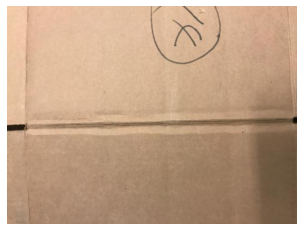

In [17]:
img_path = path_dataset + 'cardboard/cardboard1.jpg'
img = plt.imread(img_path)
print(img.shape)
plt.axis('off')
plt.imshow(img)
plt.show()


### Функция преподготовки DataFrame-ов для обучения, валидация и тестирования

In [18]:
def preprocess(sdir, trsplit, vsplit, random_seed):
    """ Возвращает DataFrame-ы для обучения, валидация и тестирования.
    
    :param sdir: Рабочая директория с датасетом
    :param trsplit: Размер обучающей выборки по соотношению к общему датасету
    :param vsplit: Размер валидационной выборки по соотношению к общему датасету 
    :param random_seed: Значение для рандомизации при делении на выборки
    """
    filepaths, labels = [], []

    # Получение всех классов и изображений
    classlist = os.listdir(sdir)
    for klass in classlist:
        classpath = os.path.join(sdir, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    # DataFrame со всем датасетом
    df = pd.concat([Fseries, Lseries], axis=1)

    # Разделение общего DataFrame на обучающую, валидирующую и тестовую выборки
    dsplit = vsplit / (1 - trsplit)
    strat = df['labels']
    # Обучающая и остальная DataFrame
    train_df, dummy_df = train_test_split(df, train_size=trsplit, shuffle=True,
                                          random_state=random_seed,
                                          stratify=strat)
    strat = dummy_df['labels']
    # DataFrame для валидации и DataFrame для тестирования
    valid_df, test_df = train_test_split(dummy_df, train_size=dsplit,
                                         shuffle=True,
                                         random_state=random_seed,
                                         stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',
          len(test_df), '  valid_df length: ', len(valid_df))

    # Проверка, что каждый DataFrame имеет одинаковое количество классов
    trcount = len(train_df['labels'].unique())
    tecount = len(test_df['labels'].unique())
    vcount = len(valid_df['labels'].unique())
    if trcount != tecount:
        msg = ('** ВНИМАНИЕ ** Количество классов в обучающей и тестовой '
               'сборках не равны')
        print_in_color(msg, (255, 0, 0), (55, 65, 80))
        msg = 'Это вызовет ошибку при model.evaluate или model.predict'
        print_in_color(msg, (255, 0, 0), (55, 65, 80))
    if trcount != vcount:
        msg = ('** ВНИМАНИЕ ** Количество классов в обучающей и '
               'валидационной выборке не равны')
        print_in_color(msg, (255, 0, 0), (55, 65, 80))
        msg = 'Это вызовет ошибку при model.fit'
        print_in_color(msg, (255, 0, 0), (55, 65, 80))
        print('Обучающая выборка: ', trcount, 'Тестовая выборка: ', tecount,
              'Валидационная выборка: ', vcount)
        ans = input('Введите F для продолжения или S для остановки программы')
        if ans == 'S' or ans == 's':
            print_in_color('Остановка выполнения', (255, 0, 0), (55, 65, 80))
            import sys
            sys.exit('Программа остановлена пользователем')

    print(list(train_df['labels'].value_counts()))
    return train_df, test_df, valid_df



In [19]:
sdir = path_dataset
train_df, test_df, valid_df = preprocess(sdir, .8, .1, 123)

train_df length:  12412   test_df length:  1552   valid_df length:  1551
[4260, 1582, 840, 788, 756, 713, 692, 620, 615, 558, 503, 485]


#### Обучающая выборка не сбалансирована

Следует подогнать выборки классов под 500 изображений в каждом.

In [20]:
# Параметры для балансировки обучающей выборки
max_samples = 500
min_samples = 0
column = 'labels'
working_dir = r'./'
img_size = (224, 224)
# Балансировка обучающей выборки
train_df = balance(train_df, max_samples, min_samples, column, working_dir,
                   img_size)

Начальное количество классов:  12
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 485]
Found 485 validated image filenames.
Всего создано дополнительных изображений =  15
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


#### Теперь в обучающей выборке (train_df) для каждого класса по 500 изображений

### Генераторы для обучения, валидации и тестирования

In [21]:
channels = 3
batch_size = 30
img_shape = (img_size[0], img_size[1], channels)
length = len(test_df)
test_batch_size = sorted(
    [int(length / n) for n in range(1, length + 1) if
     length % n == 0 and length / n <= 80], reverse=True
)[0]
test_steps = int(length / test_batch_size)
print('Размер тестового пакета: ', test_batch_size, '  Шаги тестов: ',
      test_steps)


# EfficientNet ожидает пиксели с 0 до 255, поэтому масштабирование не требуется
def scalar(img):
    return img


trgen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen = ImageDataGenerator(preprocessing_function=scalar)
train_gen = trgen.flow_from_dataframe(train_df, x_col='filepaths',
                                      y_col='labels', target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb', shuffle=True,
                                      batch_size=batch_size)
test_gen = tvgen.flow_from_dataframe(test_df, x_col='filepaths',
                                     y_col='labels', target_size=img_size,
                                     class_mode='categorical',
                                     color_mode='rgb', shuffle=False,
                                     batch_size=test_batch_size)

valid_gen = tvgen.flow_from_dataframe(valid_df, x_col='filepaths',
                                      y_col='labels', target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb', shuffle=True,
                                      batch_size=batch_size)
classes = list(train_gen.class_indices.keys())
class_count = len(classes)
train_steps = int(np.ceil(len(train_gen.labels) / batch_size))

Размер тестового пакета:  16   Шаги тестов:  97
Found 6000 validated image filenames belonging to 12 classes.
Found 1552 validated image filenames belonging to 12 classes.
Found 1551 validated image filenames belonging to 12 classes.


### Примеры обучающей выборки

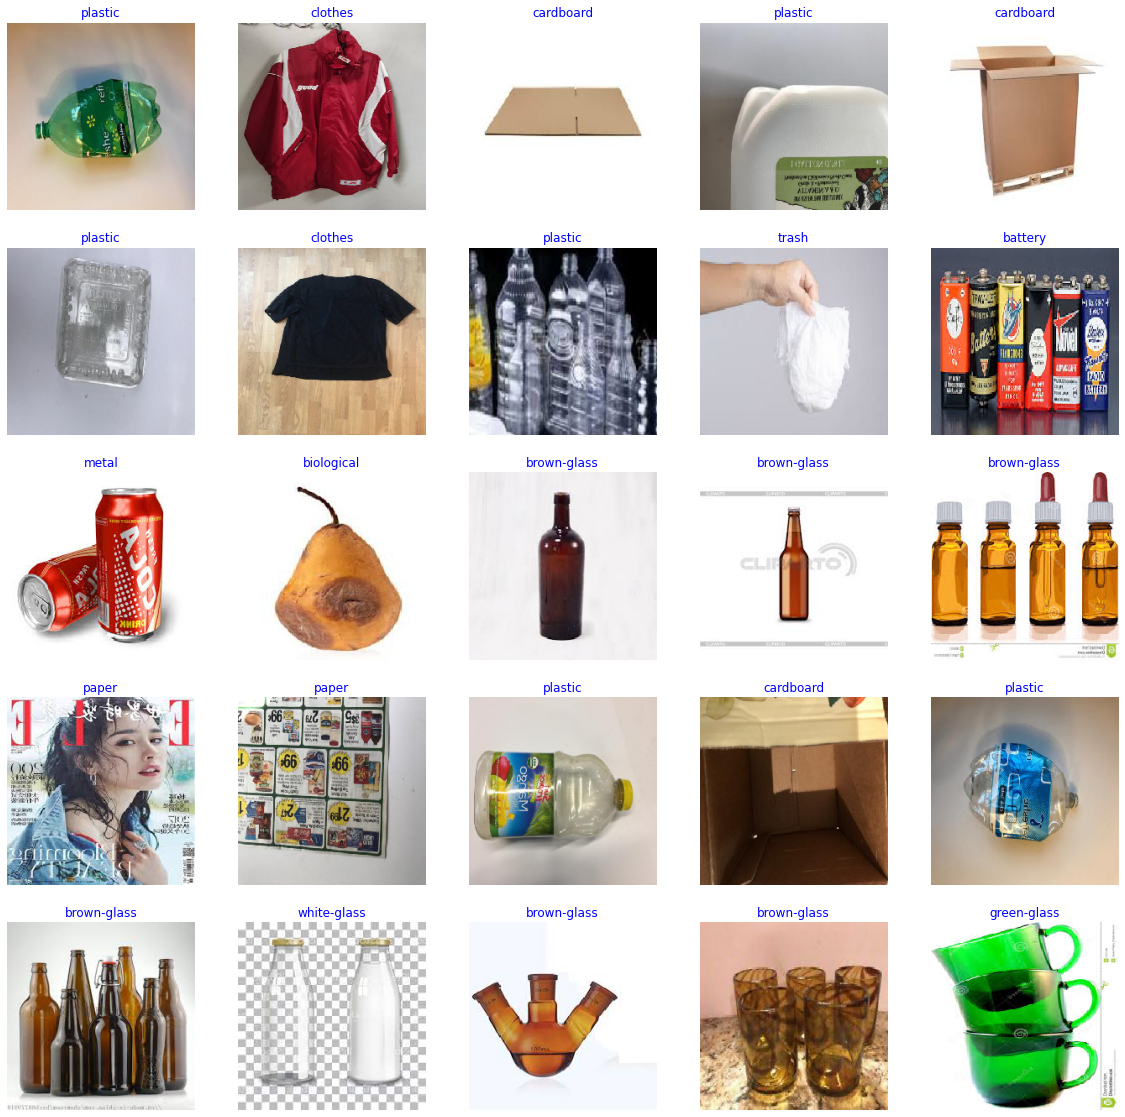

In [22]:
show_image_samples(train_gen)


### CNN модель

In [23]:
# Архитектура нейросети
model_name = 'EfficientNetB3'
base_model = tf.keras.applications.EfficientNetB3(include_top=False,
                                                  weights="imagenet",
                                                  input_shape=img_shape,
                                                  pooling='max')
x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
# Оптимизатор - Adam (самый эффективный)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy',
              metrics=['accuracy'])

43950080/43941136 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


### Обучение модели

In [24]:
# Максимальное количество эпох
epochs = 40
# Количество эпох перед корректировкой скорости обучения, если контролируемое 
# значение не улучшается
patience = 1
# Количество эпох перед остановкой обучения, если контролируемое значение не
# улучшается
stop_patience = 3
# Если точность обучения < threshold, то скорость обучения корректируется в
# зависимости от точности, в иначе - в зависимости от потерь валидации
threshold = .9
# Значение для корректировки скорости обучения
factor = .5
# Если True и отслеживаемая метрика не улучшается в текущую эпоху,
# веса модели возвращаются обратно к весам предыдущей эпохи
dwell = True
# Количество подряд обучаемых эпох перед паузой и решении о продолжении юзером
ask_epoch = 5
batches = train_steps
callbacks = [
    ControlCallback(
        model=model, base_model=base_model, patience=patience,
        stop_patience=stop_patience, threshold=threshold, factor=factor,
        dwell=dwell, batches=batches, initial_epoch=0, epochs=epochs,
        ask_epoch=ask_epoch
    )
]

history = model.fit(x=train_gen, epochs=epochs, verbose=0, callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=None, shuffle=False, initial_epoch=0)

Initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     7.266   75.800   5.42721  94.649   0.00100  0.00100  accuracy     0.00    254.10 

 2 /40     4.424   92.617   3.41237  96.389   0.00100  0.00100  val_loss    37.12    220.73 

 3 /40     2.808   95.617   2.17431  96.712   0.00100  0.00100  val_loss    36.28    220.78 

 4 /40     1.769   97.400   1.36542  97.292   0.00100  0.00100  val_loss    37.20    220.90 

 5 /40     1.112   98.283   0.89827  96.841   0.00100  0.00100  val_loss    34.21    220.75 

Введите S, чтобы остановить обучение или число эпох для запуска и повторной остановки

5
Обучение запущено для 10эпох

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 6 /40     0.743   98.517   0.62153  97.292   0.00100  0.00100  val_loss    30.81    221.04 

 7 /40     0.533   98.950   0.48284  97.357   0.00100  0.00100  val

### Оценка модели на тестовой сборке и сохранение

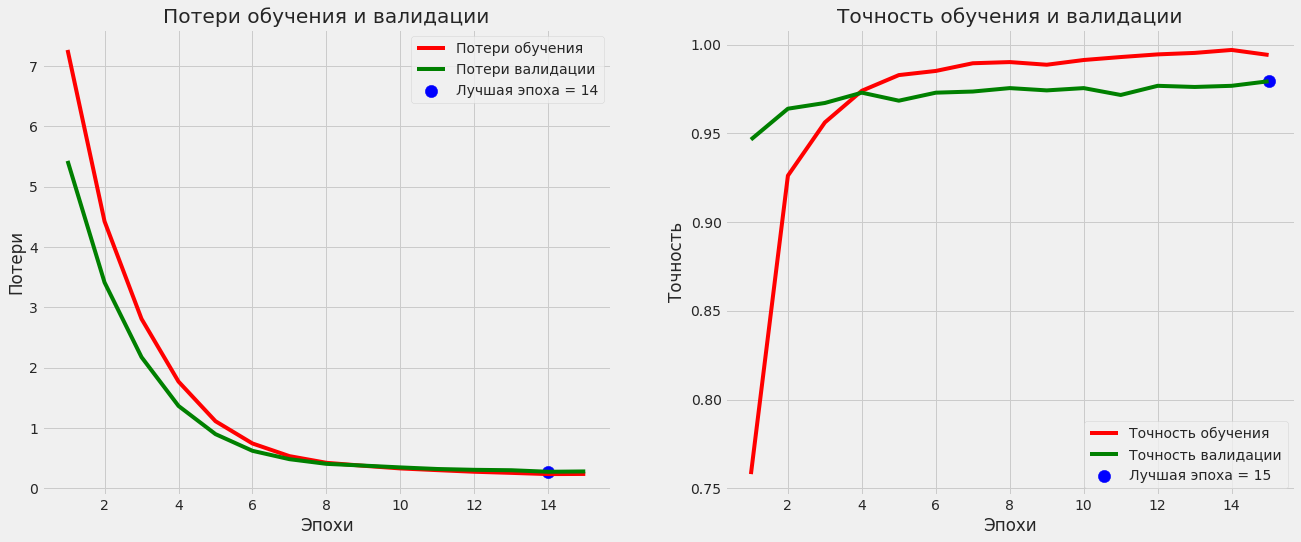

97/97 [==============================] - 14s 133ms/step - loss: 0.2924 - accuracy: 0.9704
Точность на тестовой выборке - 97.04 %

Модель сохранена в ./EfficientNetB3-garbage-97.03.h5

class_csv сохранен в ./class_dict.csv



In [25]:
# Отображение графиков обучения модели
draw_train_history(history, 0)

subject = 'garbage'

# Оценка модели на тестовой выборке
acc = model.evaluate(
    test_gen, verbose=1, steps=test_steps, return_dict=False)[1] * 100

msg = f'Точность на тестовой выборке - {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))

generator = train_gen
scale = 1
# Сохранение обученной модели
model_saved_path, csv_saved_path = model_saver(working_dir, model, model_name,
                                               subject, acc, img_size, scale,
                                               generator)

### Классификация тестовой выборки и показ отчетов

97/97 [==============================] - 15s 150ms/step


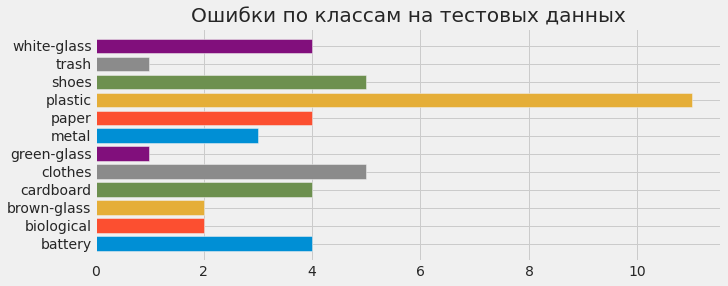

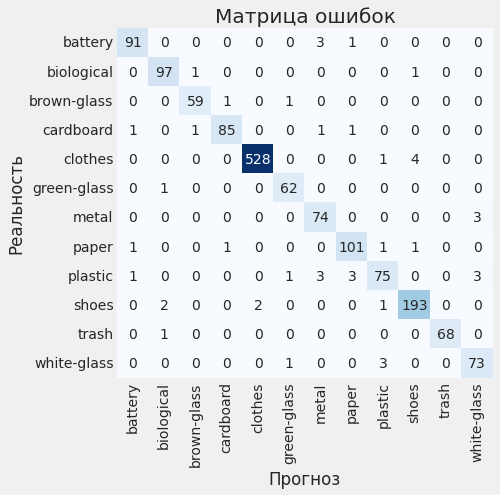

Отчет классификации:
----------------------
               precision    recall  f1-score   support

     battery       0.97      0.96      0.96        95
  biological       0.96      0.98      0.97        99
 brown-glass       0.97      0.97      0.97        61
   cardboard       0.98      0.96      0.97        89
     clothes       1.00      0.99      0.99       533
 green-glass       0.95      0.98      0.97        63
       metal       0.91      0.96      0.94        77
       paper       0.95      0.96      0.96       105
     plastic       0.93      0.87      0.90        86
       shoes       0.97      0.97      0.97       198
       trash       1.00      0.99      0.99        69
 white-glass       0.92      0.95      0.94        77

    accuracy                           0.97      1552
   macro avg       0.96      0.96      0.96      1552
weighted avg       0.97      0.97      0.97      1552



In [27]:
print_code = 0
# Классификация изображений тестовой выборки
preds = model.predict(test_gen, steps=test_steps, verbose=1)
# Отчеты по классификации
print_prediction_info(test_gen, preds, print_code)

### Сохранение модели на Google Диск

In [28]:
os.listdir()

['.config',
 '__MACOSX',
 'EfficientNetB3-garbage-97.03.h5',
 'aug',
 'class_dict.csv',
 'garbage_classification_dataset',
 'drive',
 'sample_data']

In [29]:
# Копирование сохраненной модели на Google Drive
shutil.copyfile(
    'EfficientNetB3-garbage-97.03.h5',
    'drive/MyDrive/garbage_classifier/trained_model/12_EfficientNetB3.h5'
)

'drive/MyDrive/garbage_classifier/trained_model/12_EfficientNetB3.h5'

In [30]:
# Копирование файла с классами на Google Drive
shutil.copyfile(
    'class_dict.csv',
    'drive/MyDrive/garbage_classifier/trained_model/12_class_dict.csv'
)

'drive/MyDrive/garbage_classifier/trained_model/12_class_dict.csv'

### Тестовый запуск модели на изображении

In [31]:
store_path = os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
# Чтение изображения
img = cv2.imread(img_path, cv2.IMREAD_REDUCED_COLOR_2)
file_name = os.path.split(img_path)[1]
dst_path = os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
# check if the directory was created and image stored
print(os.listdir(store_path))

['cardboard1.jpg']


image is of class cardboard with a probability of  98.78 %



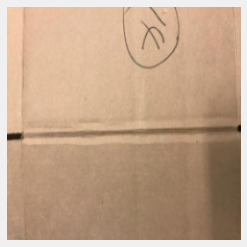

In [41]:
# Сохраненный словарь классов
csv_path = csv_saved_path
# Сохраненная модель
model_path = model_saved_path
# Запуск классификатора
klass, prob, img, df = predictor(store_path, csv_path, model_path,
                                 averaged=True)
msg = f'image is of class {klass} with a probability of {prob * 100: 6.2f} %'
plt.axis('off')
plt.imshow(img)
print_in_color(msg, (0, 255, 255), (65, 85, 55))